In [372]:
import pyvis
import pandas as pd

import networkx as nx
import numpy as np
from operator import itemgetter, attrgetter
from networkx.algorithms import tree, community
from networkx.generators.ego import ego_graph
import matplotlib.pylab as plt
from pyvis.network import Network

A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. Each github user is classes as either a web developer or machine learning engineer.

In [384]:
# stanford dataset network site https://snap.stanford.edu/data

path_edges = "../data/github_users_network/musae_git_edges.csv"
path_target = "../data/github_users_network/musae_git_target.csv"

var_options ="""
var options = {
  "physics": {
    "repulsion": {
      "springLength": 225,
      "springConstant": 0.02,
      "nodeDistance": 330,
      "damping": 0.08
    },
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}
"""

def reader(path_reader, path_target):
    df_edges = pd.read_csv(path_edges)
    df_target = pd.read_csv(path_target)
    return df_edges, df_target

def create_network_from_df(df):
    df = df.rename(columns={df.columns[0]: 'source', df.columns[1]: 'target'})
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(df,  create_using=Graphtype)
    return G
    #print(nx.info(G))
    #G.edges
    
    
def get_edge_list(G, sort=True):
    if sort:
        # sort by node 1
        sorted_edges = sorted(G.edges(), key=lambda x: x[0], reverse=True)
        return sorted_edges
    else:
        return list(G.edges())


def list_duplicate_edges(G):
    dup = list(duplicates(get_edge_list(G)))
    if len(dup) > 0:
        print(f"{len(dup)} duplicates found")
    return dup
    
def remove_nodes_with_low_degree(G, n):
    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    #keep top n nodes 
    node_list_remove = [node for node, v in degree_sorted[n::]]
    G.remove_nodes_from(node_list_remove)
    return G


def draw_network(G, notebook=True, physics=True, config=None):
    if notebook:
        nt = Network(height='750px', width='100%',notebook=True)
    else:
        nt = Network(height='750px', width='100%')
    nt.from_nx(G)
    if physics:
        nt.show_buttons(filter_=['physics'])
    if config is not None:
        nt.set_options(config) 
    return nt

def max_spanning_tree(G, algorithm="kruskal"):
    mst = tree.maximum_spanning_edges(G, algorithm=algorithm, data=False)
    edge_list = list(mst)
    G = nx.Graph()
    G.add_edges_from(edge_list)  # using a list of edge tuples
    return G
    
def compute_metrics(G):
    degree = dict(G.degree(G.nodes()))
    betweenness = nx.betweenness_centrality(G) # Run betweenness centrality
    clo_cen = nx.closeness_centrality(G)
    # Eigenvector centrality
    eig_cen = nx.eigenvector_centrality(G)
    return degree, betweenness, clo_cen, eig_cen
    
    
def community_detection(G):
    communities = community.greedy_modularity_communities(G)
    modularity_dict = {} # Create a blank dictionary
    for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
        for name in c: # Loop through each person in a community
            modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

    return communities, modularity_dict
    
    
def set_attributes(G, **kwargs):
    for key in kwargs.keys(): 
        nx.set_node_attributes(G, kwargs[key],key)
    return G

    
def top_betweeness_nodes_with_attributes(G, top_n=20):
    betweenness_dict = nx.get_node_attributes(G,'betweeness')
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    #First get the top n nodes by betweenness as a list
    top_betweenness = sorted_betweenness[:top_n]
    degree_list = []
    modularity_list = []
    eig_list = []
    closeness_list = []
    node_id = []
    betweenness_list = []
    #Then find and print their corresponding attributes: degree,  modularity
    for tb in top_betweenness: # Loop through top_betweenness
        degree = nx.get_node_attributes(G,'degree')[tb[0]] # Use degree_dict to access a node's degree
        modularity = nx.get_node_attributes(G,'modularity')[tb[0]]
        closeness = nx.get_node_attributes(G,'closeness')[tb[0]]
        eigenvector = nx.get_node_attributes(G,'eigenvector')[tb[0]]
        closeness_list.append(closeness)
        eig_list.append(eigenvector)
        degree_list.append(degree)
        modularity_list.append(modularity)
        betweenness_list.append(tb[1])
        node_id.append(tb[0])
        #print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree, "| Modularity", modularity)
    return pd.DataFrame({'id':node_id, 'betweeness': betweenness_list, 
                         'Degree': degree_list, 'eigenvector':eig_list, 'closeness' : closeness_list, 'Modularity': modularity_list})
        
def shortest_path(G, source_id, target_id):
    shortest_path = nx.shortest_path(G, source=source_id, target=target_id)
    print("Shortest path between user1 and user2:", shortest_path)
    return shortest_path

def plot_community_class_count(communities):
    count_list = []
    class_list = []
    for i,c in enumerate(communities):
        class_list.append(i)
        count_list.append(len(list(c)))

    df = pd.DataFrame({'class':class_list, 'count':count_list})
    df.plot.bar(x='class', y='count')
    return df

def connected_components(G, subgraph=False, node_list=None):
    # use nx.connected_components to get the list of components,
    # then use the max() command to find the largest one:
    components = nx.connected_components(G)
    print(components)
    largest_component = max(components, key=len)
    return components, largest_component

def plot_subgraph(G, node_list):
    subgraph = G.subgraph(node_list)
    diameter = nx.diameter(subgraph)
    print("Network diameter of largest component:", diameter)
    nt = draw_network(subgraph)
    return nt

def plot_ego_network(G, n, radius):
    """
    plot ego network around a node n depending
    on radius setting i.e. only include upto
    n nodes directly or indirectly connected to
    this node
    """
    ego_nx = ego_graph(G, n, radius=radius)
    nt = draw_network(ego_nx)
    return nt
    

def create_bridge_network(G):
    bridges = list(nx.bridges(G))
    edges = G.edges()
    edgecolor = []
    for a in edges:
        if any([a==b for b in bridges]):
            edgecolor.append('red')
        else:
            edgecolor.append('lightblue')
    return bridges, edgecolor

def assortativity(G):
    return nx.degree_assortativity_coefficient(G)

def export_graph(G, path='../data/github_network.gexf'):
    nx.write_gexf(G, path)



#### Read in dataset and plot graph after restriocting to top 1000  nodes with higest degree

The  lets prune this by running max weighted spanning tree algo

In [385]:
df_edges, df_target = reader(path_edges, path_target) 
main_nx = create_network_from_df(df_edges)
main_nx = remove_nodes_with_low_degree(main_nx, n=50)
nt= draw_network(main_nx, config=None)
nt.show('outputs/original_net_top_50_degree.html')


#### Compute metrics and list metrics for top betweeness centralty nodes

In [342]:
degree, betweenness, clo, eig = compute_metrics(main_nx)
metrics = {'degree': degree, 'betweeness': betweenness, 'closeness': clo, 'eigenvector': eig}
metrics_main_nx = pd.DataFrame(metrics)

Text(0, 0.5, 'Frequency')

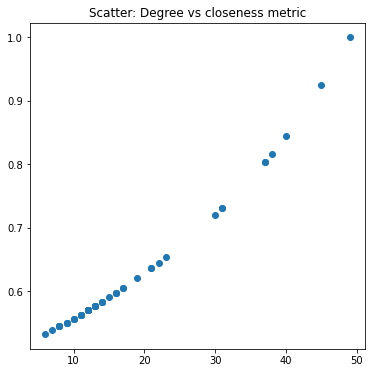

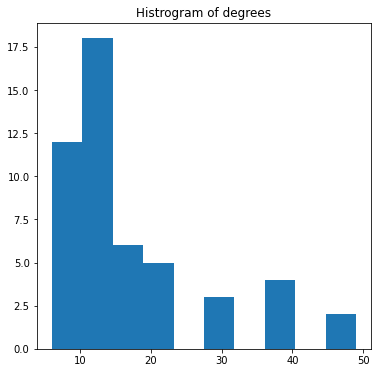

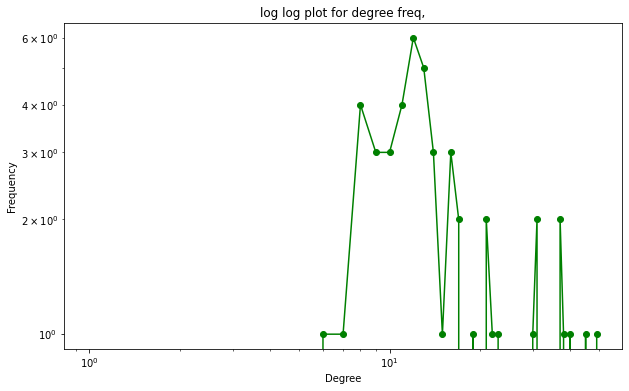

In [343]:
# this returns the entire graph as only one component in this graph 

plt.figure(figsize=(6, 6)) 
plt.scatter(metrics_main_nx['degree'], metrics_main_nx['closeness'])
plt.title('Scatter: Degree vs closeness metric')

plt.figure(figsize=(6, 6)) 
plt.hist(metrics_main_nx['degree'])
plt.title('Histrogram of degrees')

m=1
degree_freq = nx.degree_histogram(main_nx)
degrees = range(len(degree_freq))
plt.figure(figsize=(10, 6)) 
plt.loglog(degrees[m:], degree_freq[m:],'go-') 
plt.title('log log plot for degree freq,')
plt.xlabel('Degree')
plt.ylabel('Frequency')

#### Kruskal algo  - Max Weighted Spanning tree

In [376]:
prune_nx =  max_spanning_tree(main_nx, algorithm="kruskal")
nt= draw_network(prune_nx)
nt.show('outputs/mst_network.html')

#### Community Detection

In [347]:
communities, modularity = community_detection(prune_nx)
degree, betweenness, clo, eig = compute_metrics(prune_nx)
metrics = {'degree': degree, 'betweeness': betweenness, 'closeness': clo, 'eigenvector': eig, 'modularity': modularity}
prune_nx = set_attributes(prune_nx, **metrics)
metrics = top_betweeness_nodes_with_attributes(prune_nx, top_n=40)
metrics.head(20)

,id,betweeness,Degree,eigenvector,closeness,Modularity
0,27803,0.953231,39,0.703033,0.830508,0
1,21142,0.369898,11,0.150289,0.563218,1
2,3153,0.000000,1,0.023961,0.362963,1
3,5629,0.000000,1,0.023961,0.362963,1
4,10001,0.000000,1,0.023961,0.362963,1
5,11279,0.000000,1,0.023961,0.362963,1
6,19222,0.000000,1,0.023961,0.362963,1
7,3712,0.000000,1,0.023961,0.362963,1
8,31890,0.000000,1,0.023961,0.362963,1
9,30002,0.000000,1,0.023961,0.362963,1


check out who these top 3 people are by joining on target df


Shortest path between user1 and user2: [27803, 9051]


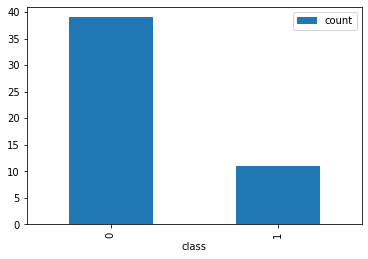

In [348]:

shortest = shortest_path(prune_nx, source_id=27803, target_id=9051)
community_count = plot_community_class_count(communities)

In [351]:
top_nodes_labels = metrics.iloc[0:3, :].merge(df_target, on='id')[['id', 'name', 'ml_target']]
top_nodes_labels

,id,name,ml_target
0,27803,nfultz,0
1,21142,fengmk2,0
2,3153,sorrycc,0


#### subgraph with commuity groups 

In [399]:

components, largest_component = connected_components(prune_nx)
nt = plot_subgraph(prune_nx, largest_component)
mapper = {0:'red', 1: 'yellow', 2: 'green', 3:'orange', 4: 'brown', 5: 'purple', 6:'pink'}

node_id_list = list(metrics['id'].values)

for node in nt.nodes:
    if node['id'] in node_id_list:
        mod = metrics.loc[metrics['id']== node['id'], 'Modularity'].values[0]
        node['color'] = mapper[mod]
        
nt.show('outputs/subgraph.html')

<generator object connected_components at 0x7fbbeb95f9e0>
Network diameter of largest component: 3



#### Ego Network

pick node with highest betweeness centrality and plot ego network with radius 2 

In [400]:
node_id = 27803

nt = plot_ego_network(prune_nx, node_id, radius = 1)
for node in nt.nodes:
    if node['id'] == node_id:
        mod = metrics.loc[metrics['id']== node['id'], 'Modularity'].values[0]
        node['color'] = mapper[mod]
nt.show('outputs/ego.html')

#### Node2vec Embeddings on Movie Lens dataset 



The Node2Vec algorithm is a method for learning continuous feature representations for nodes in networks. This approach can simply be described as a mapping of nodes to a low dimensional space of features that maximizes the likelihood of persevering neighborhood structure of the nodes. This approach is not tied to a fixed definition of neighborhood of a node but can be used in conjunction with different notions of node neighborhood, such as, homophily or structural equivalence, among other concepts. The algorithm efficiently explores diverse neighborhoods of nodes through a biased random walk procedure that is parametrized to emulate a specific concept of the neighborhood of a node.

Once a predefined number of walks, of fixed lengths, have been sampled, the low dimension embedding vectors of nodes can be learnt using Word2vec algorithm. We use the Word2Vec implementation in the free Python library Gensim to learn representations for each node in the graph.

In [389]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline



#### Implement the biased random walk
A random walk starts from a given node, and randomly picks a neighbour node to move to.
If the edges are weighted, the neighbour is selected *probabilistically* with
respect to weights of the edges between the current node and its neighbours.
This procedure is repeated for `num_steps` to generate a sequence of *related* nodes.
The [*biased* random walk](https://en.wikipedia.org/wiki/Biased_random_walk_on_a_graph) balances between **breadth-first sampling**
(where only local neighbours are visited) and **depth-first sampling**
(where  distant neighbours are visited) by introducing the following two parameters:
1. **Return parameter** (`p`): Controls the likelihood of immediately revisiting
a node in the walk. Setting it to a high value encourages moderate exploration,
while setting it to a low value would keep the walk local.
2. **In-out parameter** (`q`): Allows the search to differentiate
between *inward* and *outward* nodes. Setting it to a high value biases the
random walk towards local nodes, while setting it to a low value biases the walk
to visit nodes which are further away.
"""


In [390]:
from zipfile import ZipFile
from urllib.request import urlretrieve

urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()


# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

full_df = ratings.merge(movies, how='inner', on='movieId')
full_df['genres'] = full_df['genres'].map(lambda x: x.strip().split('|')[-1])
full_df

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


,userId,movieId,rating,timestamp,title,genres
0,1,movie_1,4.0,964982703,Toy Story (1995),Fantasy
1,5,movie_1,4.0,847434962,Toy Story (1995),Fantasy
2,7,movie_1,4.5,1106635946,Toy Story (1995),Fantasy
3,15,movie_1,2.5,1510577970,Toy Story (1995),Fantasy
4,17,movie_1,4.5,1305696483,Toy Story (1995),Fantasy
...,...,...,...,...,...,...
100831,610,movie_160341,2.5,1479545749,Bloodmoon (1997),Thriller
100832,610,movie_160527,4.5,1479544998,Sympathy for the Underdog (1971),Drama
100833,610,movie_160836,3.0,1493844794,Hazard (2005),Thriller
100834,610,movie_163937,3.5,1493848789,Blair Witch (2016),Thriller


In [356]:
label_map = full_df.loc[:, ['title', 'genres']].set_index('title')['genres'].to_dict()



In [391]:

from collections import defaultdict
from tqdm import tqdm

min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)


# Filter instances where rating is greater than or equal to min_rating.
rated_movies = full_df[full_df.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["title"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|█████| 573/573 [00:00<00:00, 1354.49it/s]


In [392]:
import math

min_weight = 60
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
G = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        G.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|█████| 298586/298586 [00:00<00:00, 822181.25it/s]


In [393]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 98
Total number of graph edges: 446


##### Bridges

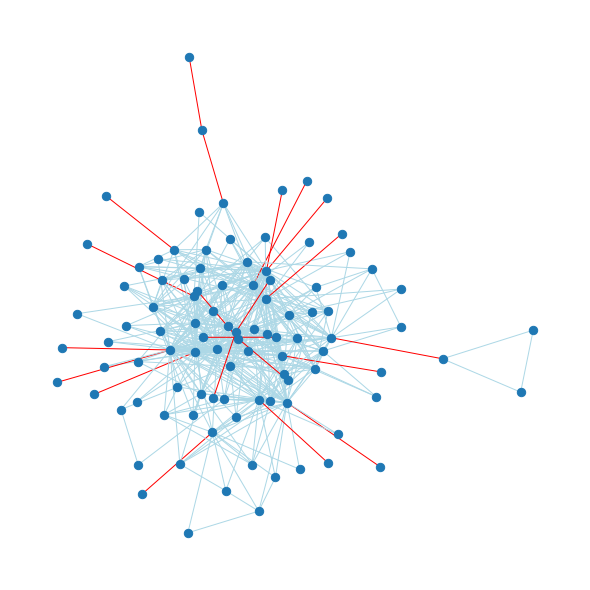

In [398]:



bridges, edgecolor = create_bridge_network(G)

plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(G, node_size=70, edge_color=edgecolor, arrowsize=5)

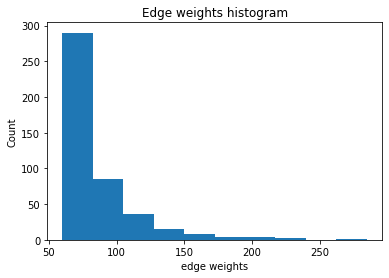

In [361]:
weights = []

for i in range(len(movies_graph.edges)):
    weights.append(list((list(movies_graph.edges(data=True))[i][2].values()))[0])

plt.title("Edge weights histogram")
plt.hist(weights)
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.show()


In [362]:
nt= draw_network(movies_graph, config=None)
nt.show('outputs/movie_graph.html')

In [377]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 9.1


In [378]:
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

G= StellarGraph.from_networkx(movies_graph)
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 980


In [379]:
model = Word2Vec(
walks, vector_size=500, window=5, min_count=0, sg=1, workers=1, epochs=1
)
# The embedding vectors can be retrieved from model.wv using the node ID as key.
node_embeddings = model.wv.vectors
node_embeddings

array([[ 0.093437  ,  0.05432752,  0.08226734, ...,  0.01974924,
        -0.07006274, -0.02105042],
       [ 0.05610358,  0.03922865,  0.07556939, ...,  0.05641441,
        -0.08490968, -0.00452363],
       [ 0.06597364,  0.03534111,  0.07974451, ...,  0.03707861,
        -0.09125711,  0.01709468],
       ...,
       [ 0.05328187,  0.04021085,  0.08423054, ...,  0.01614701,
        -0.07279991, -0.02049792],
       [ 0.01740944,  0.02556419,  0.07633385, ...,  0.02541122,
        -0.08965582, -0.00533433],
       [ 0.06929216,  0.04798625,  0.07827598, ..., -0.00855811,
        -0.06184783, -0.0233797 ]], dtype=float32)

In [380]:
node_ids = model.wv.index_to_key  # list of node IDs
node_targets = [label_map[node] for node in node_ids]

node_targets = pd.Series(node_targets).astype('category') 
node_col = node_targets.cat.codes

In [381]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

/Users/rk1103/opt/miniconda3/envs/net/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rk1103/opt/miniconda3/envs/net/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


No handles with labels found to put in legend.


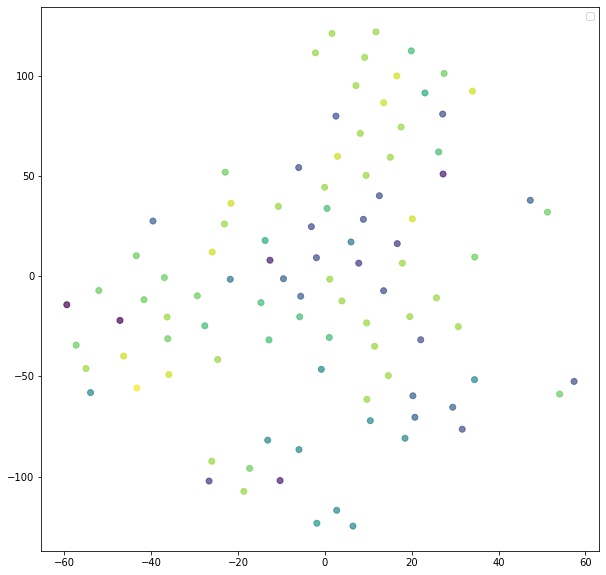

In [401]:
# draw the points
alpha = 0.7
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
#node_colours = [label_map[target] for target in node3_targets]

plt.figure(figsize=(10,10))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_col,
    alpha=alpha,
)
plt.legend()

In [383]:
node_targets

0     Thriller
1     Thriller
2       Sci-Fi
3       Sci-Fi
4        Drama
        ...   
93         War
94       Crime
95       Crime
96        IMAX
97      Comedy
Length: 98, dtype: category
Categories (14, object): ['Adventure', 'Comedy', 'Crime', 'Drama', ..., 'Sci-Fi', 'Thriller', 'War', 'Western']